In [1]:
import csv
import numpy as np
import pandas as pd
import random

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import threading

In [4]:
import random
import time
random.seed = 208

In [5]:
f = open("proximityedgestimestamps.csv", "r")

In [6]:
t = pd.read_csv(
    f,
    header=None,
    delimiter=";",
    names=["Timestamp", "Device 1", "Device 2"],
    dtype=np.int32)

In [7]:
nu_data = t.as_matrix()

In [8]:
nu_data.shape

(272165, 3)

In [9]:
f.close()

In [10]:
t[:10]

,Timestamp,Device 1,Device 2
0,21,26,5844
1,21,26,588
2,29,27,321
3,30,32,3
4,30,32,533
5,30,32,836
6,30,32,837
7,31,31,548
8,41,25,1172
9,41,25,572


Preliminary analysis shows that device id's are in the range **1 to 11934** and time is in range **21 to 349811**

In [11]:
t.describe()

,Timestamp,Device 1,Device 2
count,272165.000000,272165.000000,272165.000000
mean,102423.374111,39.241651,836.406088
std,71762.366982,21.911135,1792.371328
min,21.000000,1.000000,1.000000
25%,32441.000000,19.000000,76.000000
50%,100237.000000,39.000000,547.000000
75%,179755.000000,60.000000,585.000000
max,349811.000000,76.000000,11934.000000


In [12]:
device_set = set()

In [13]:
for idx, row in t.iterrows():
    device_set.add(row[1])
    device_set.add(row[2])

So we get 1723 device IDs

In [14]:
device_list = list(device_set)

In [15]:
device_list.sort()

In [16]:
random_sample = random.sample(device_list, 100)

## Part 1

In [ ]:
class Device_1:
    def __init__(self, id, has_chunk, num_forwards_initial):
        self.idx = id
        self.has_chunk = has_chunk
        self.num_forwards = num_forwards_initial


#       self.transmitted_to = set()

    def try_forward(self, target_device):
        if (self.has_chunk and (not target_device.has_chunk)
                and (self.num_forwards > 0)):
            self.num_forwards = self.num_forwards - 1
            target_device.has_chunk = True
            return 1
        return 0

    def __str__(self):
        s = ""
        s = s + "Device with ID " + str(self.idx)
        if self.has_chunk:
            s = s + ". I have the chunk and have " + str(
                self.num_forwards) + " forwards remaining"
        else:
            s = s + ". I don't have the chunk and have " + str(
                self.num_forwards) + " forwards remaining"
        return s

In [ ]:
def do_exp1(K,
            list_to_append_to,
            thresh=0.90,
            device_list=device_list,
            data=nu_data,
            start_node=26):
    num_received = 1
    num_total_devices = len(device_list)
    percent_devices_received = num_received / num_total_devices
    end_timestep = 0
    dict_devices = {}
    for dev in device_list:
        dict_devices[dev] = Device_1(dev, False, K)
    dict_devices[start_node].has_chunk = True
    reached_thresh = False
    for row in nu_data:
        timestep = row[0]
        device_1 = dict_devices[row[1]]
        device_2 = dict_devices[row[2]]
        num_received += device_1.try_forward(device_2)
        num_received += device_2.try_forward(device_1)
        percent_devices_received = num_received / num_total_devices
        if percent_devices_received > thresh:
            end_timestep = timestep
            reached_thresh = True
            break
    list_to_append_to.append((K, reached_thresh, num_received, end_timestep))

In [ ]:
start = time.time()
thl = []
list_of_results = []
for K in range(1, 91):
    nt = threading.Thread(target=do_exp1, args=(K, list_of_results))
    thl.append(nt)
    nt.start()
for ele in thl:
    ele.join()
print(time.time() - start)

In [ ]:
list_of_results.sort(key=lambda x: x[0])

In [ ]:
results_not_reached_thresh = []
results_reached_thresh = []
for res in list_of_results:
    if not res[1]:
        results_not_reached_thresh.append([res[0], res[2]])
    else:
        results_reached_thresh.append([res[0], res[3]])

In [ ]:
n_df = pd.DataFrame(
    results_not_reached_thresh, columns=["K", "Number_Received"])
y_df = pd.DataFrame(results_reached_thresh, columns=["K", "Time_Taken"])

In [ ]:
sns.lmplot(x="K", y="Number_Received", data=n_df, fit_reg=False)

In [ ]:
sns.lmplot(x="K", y="Time_Taken", data=y_df, fit_reg=False)

**(a)** These two plots represent what happens to the _distribution of chunks_ with changing K values. We see that from **K = 1 to K = 48 the chunks don't reach** the necessary 90% of nodes and we plot the number of nodes that have received the chunk at the end. For **K = 50 to K = 90** (and beyond) the chunks do reach 90% of the nodes and we plot the time taken to reach 90% nodes. The relationships can be easily seen. In the earlier case the number of nodes getting the messages increases with increasing K (in a logarithmic fashion), while in the latter example the time taken decreases with increasing K, finally saturating at **t = 205775 reached first at K = 80**.

**(b)** The number of copies of the chunk made equals the number of nodes that have received the broadcast.

In [ ]:
start = time.time()
thl = []
dict_of_results = {}
for K in range(1, 91):
    dict_of_results[K] = []
    for start_device in random_sample:
        nt = threading.Thread(
            target=do_exp1,
            args=(K, dict_of_results[K]),
            kwargs={
                "start_node": start_device
            })
        thl.append(nt)
        nt.start()
for ele in thl:
    ele.join()
print(time.time() - start)

In [ ]:
import pickle
with open("exp1_res", "wb") as f:
    pickle.dump(dict_of_results, f, pickle.HIGHEST_PROTOCOL)
# with open("super.file", "rb") as f:
#     dump = pickle.load(f)

In [ ]:
l = []
for key, el in dict_of_results.items():
    ll = []
    for tup in el:
        ll.append(tup[2])
    l.append(ll)

In [ ]:
nd = np.asarray(l)
means = nd.mean(axis=1)
stds = nd.std(axis=1)
vals = np.asarray(range(1, 91))
means = means.squeeze()
stds = stds.squeeze()
res_df = pd.DataFrame(data={"K": vals, "Mean": means, "Std Dev": stds})

In [ ]:
plt.errorbar(vals, means, yerr=stds, ecolor="red")
plt.xlabel("K")
plt.ylabel("Nodes Received")

Here we have plotted the nodes that received the transmissions as a function of K for **100 starting nodes **with mean and error bars. After some steps is the time taken plot.

In [ ]:
l = []

In [ ]:
for key, el in dict_of_results.items():
    ll = []
    for tup in el:
        if tup[1]:
            ll.append(tup[3])
    l.append(ll)

Starting from K = 47

In [ ]:
l = [el for el in l if el != []]

In [ ]:
means = [np.mean(i) for i in l]
stds = [np.std(i) for i in l]

In [ ]:
vals = [i for i in range(47, 91)]

In [ ]:
res_df = pd.DataFrame(data={"K": vals, "Mean": means, "Std Dev": stds})

In [ ]:
plt.errorbar(vals, means, yerr=stds, ecolor="red")
plt.xlabel("K")
plt.ylabel("Time Taken")

**(c)** This is the plot of time taken with K, computed as mean over 100 starting nodes. Only starting nodes where we reach 90% are considered in taking the average. We also plot the standard deviation as error bars. We can see that the trend observed earlier is observed here too, specifically **time taken reduces with increasing K**. Near the end a small bump is observed which could be beacause by increasing K we are getting some more nodes into the average (due to them hitting the threshold), thereby increasing the average time taken.

## Part 2

In [17]:
class Device_2:
    def __init__(self,
                 idx,
                 degree,
                 has_chunk,
                 is_super_node,
                 is_least_mobile_node,
                 super_transmit_prob,
                 normal_transmit_prob,
                 least_transmit_prob=1):
        self.idx = idx
        self.degree = degree
        self.num_transmissions_done = 0
        self.has_chunk = has_chunk
        self.is_super_node = is_super_node
        self.is_least_mobile_node = is_least_mobile_node
        self.super_transmit_prob = super_transmit_prob
        self.normal_transmit_prob = normal_transmit_prob
        self.least_transmit_prob = least_transmit_prob
        assert not (is_least_mobile_node and is_super_node)

    def try_forward(self, target_device):
        if (self.has_chunk and (not target_device.has_chunk)):
            if target_device.is_least_mobile_node:
                if random.random() < self.least_transmit_prob:
                    return self.do_forward(target_device)
            elif target_device.is_super_node:
                if random.random() < self.super_transmit_prob:
                    return self.do_forward(target_device)
            else:
                if random.random() < self.normal_transmit_prob:
                    return self.do_forward(target_device)
        return 0

    def do_forward(self, target_device):
        target_device.has_chunk = True
        self.num_transmissions_done = self.num_transmissions_done + 1
        return 1

    def __str__(self):
        s = ""
        s = s + "I am device with ID " + str(self.idx) + " and degree " + str(
            self.degree) + " "
        if self.is_super_node: s = s + " (am super node) "
        if self.is_least_mobile_node: s = s + " (am least mobile node) "
        if self.has_chunk: s = s + ". I have the chunk"
        else: s = s + ". I don't have the chunk."
        return s

In [18]:
degree_dict = {}
neigh_dict = {}
for i in device_list:
    degree_dict[i] = 0
    neigh_dict[i] = []

In [19]:
for row in nu_data:
    if row[2] not in neigh_dict[row[1]]:
        degree_dict[row[1]] += 1
        neigh_dict[row[1]].append(row[2])
    if row[1] not in neigh_dict[row[2]]:
        degree_dict[row[2]] += 1
        neigh_dict[row[2]].append(row[1])

In [20]:
degrees = degree_dict.values()
maxy = max(degrees)
miny = min(degrees)
lis = []
for d in range(miny, maxy + 1):
    lis.append((d, sum(i <= d for i in degrees)))

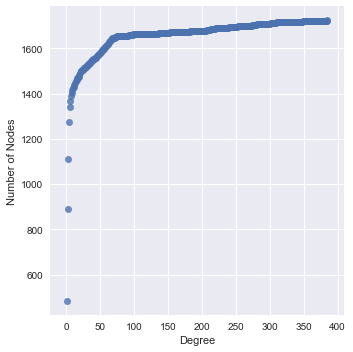

In [21]:
num_df = pd.DataFrame(data=lis, columns=["Degree", "Number of Nodes"])
sns.lmplot(x="Degree", y="Number of Nodes", data=num_df, fit_reg=False)

In [22]:
import math
log_log_list = [[i, math.log(math.log(j))] for i, j in lis]

In [23]:
cum_df = pd.DataFrame(
    data=log_log_list, columns=["Degree", "Log Log Number of Nodes"])

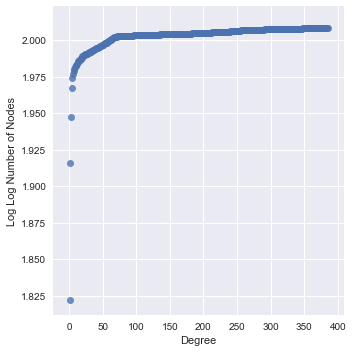

In [24]:
sns.lmplot(x="Degree", y="Log Log Number of Nodes", data=cum_df, fit_reg=False)

This is the cumulative distribution plot of the **number of nodes with the degree of the nodes**. As can be seen, **most of the nodes have small degrees** and the latter part of the graph is basically a straight line.

In [ ]:
def do_exp2(list_to_append_to,
            super_node_percentile=0.5,
            least_mobile_percentile=70,
            super_node_prob=0.5,
            normal_node_prob=0.5,
            thresh=0.90,
            degree_dict=degree_dict,
            device_list=device_list,
            data=nu_data,
            start_node=26):

    num_received = 1
    num_total_devices = len(device_list)
    percent_devices_received = num_received / num_total_devices
    end_timestep = 0

    super_node_percentile = super_node_percentile  # from top
    least_mobile_percentile = least_mobile_percentile  # from bottom

    super_node_prob = super_node_prob
    normal_node_prob = normal_node_prob  # arbitrary assumption

    degree_list = list(degree_dict.values())
    super_node_cutoff = np.percentile(degree_list, 100 - super_node_percentile)
    least_mobile_cutoff = np.percentile(degree_list, least_mobile_percentile)

    dict_devices = {}

    for dev in device_list:
        if (degree_dict[dev] < least_mobile_cutoff):
            dict_devices[dev] = Device_2(dev, degree_dict[dev], False, False,
                                         True, super_node_prob,
                                         normal_node_prob)
        elif (degree_dict[dev] > super_node_cutoff):
            dict_devices[dev] = Device_2(dev, degree_dict[dev], False, True,
                                         False, super_node_prob,
                                         normal_node_prob)
        else:
            dict_devices[dev] = Device_2(dev, degree_dict[dev], False, False,
                                         False, super_node_prob,
                                         normal_node_prob)

    dict_devices[start_node].has_chunk = True
    reached_thresh = False

    for row in nu_data:
        timestep = row[0]
        device_1 = dict_devices[row[1]]
        device_2 = dict_devices[row[2]]
        num_received += device_1.try_forward(device_2)
        num_received += device_2.try_forward(device_1)
        percent_devices_received = num_received / num_total_devices
        if percent_devices_received > thresh:
            end_timestep = timestep
            reached_thresh = True
            break

    num_normal = 0
    num_super = 0
    num_least = 0

    tot_normal = 0
    tot_super = 0
    tot_least = 0

    num_transmission_done_list = []

    for (iden, device) in dict_devices.items():
        num_transmission_done_list.append(device.num_transmissions_done)
        if device.is_super_node:
            num_super += 1
            tot_super += device.num_transmissions_done
            assert not device.is_least_mobile_node
        elif device.is_least_mobile_node:
            num_least += 1
            tot_least += device.num_transmissions_done
            assert not device.is_super_node
        else:
            num_normal += 1
            tot_normal += device.num_transmissions_done
            assert not device.is_super_node
            assert not device.is_least_mobile_node

    mean_normal = tot_normal / num_normal
    mean_super = tot_super / num_super
    mean_least = tot_least / num_least

    num_transmission_done_arr = np.asarray(num_transmission_done_list)

    two_diff_sum = np.sum(
        np.abs(num_transmission_done_arr[:, np.newaxis] -
               num_transmission_done_arr))
    gini = two_diff_sum / (2 * len(num_transmission_done_list) *
                           (0.000001 + np.sum(num_transmission_done_arr)))

    list_to_append_to.append(
        (super_node_prob, reached_thresh, num_received, end_timestep,
         mean_normal, mean_super, mean_least, gini))

In [ ]:
tl = []
do_exp2(tl)

In [ ]:
tl

In [ ]:
probs = np.linspace(0, 1, num=100)

In [ ]:
start = time.time()
thl = []
list_of_results = []
for p in probs:
    nt = threading.Thread(
        target=do_exp2,
        args=(list_of_results, ),
        kwargs={
            "super_node_prob": p,
            "normal_node_prob": 1 - p
        })
    thl.append(nt)
    nt.start()
for ele in thl:
    ele.join()
print(time.time() - start)

In [ ]:
res = pd.DataFrame(
    list_of_results,
    columns=[
        "Super Node Probability", "Reached Threshold", "Nodes Reached",
        "Time Taken", "Mean Normal Transmissions", "Mean Super Transmissions",
        "Mean Least Mobile Transmissions", "Gini Coeff."
    ])

In [ ]:
res[:5]

In [ ]:
res[-5:]

As we see only when Super node probability becomes very large ( >0.96 ), normal node probability decreases very much and therefore we are not able to reach the threshold in the given time

In [ ]:
sns.lmplot(
    x="Super Node Probability", y="Time Taken", data=res[:-3],
    fit_reg=True)  # ignoring where we don't reach thresh
sns.lmplot(
    x="Super Node Probability",
    y="Mean Super Transmissions",
    data=res,
    fit_reg=True)
sns.lmplot(
    x="Super Node Probability",
    y="Mean Normal Transmissions",
    data=res,
    fit_reg=True)
sns.lmplot(
    x="Super Node Probability",
    y="Mean Least Mobile Transmissions",
    data=res,
    fit_reg=True)

**(a)** The plots show the time taken and the mean number of transmissions by different categories of devices plotted with respect to the super node transmission probability. Note that **normal node probability is one minus the super node probability**.  
A clear upward trend in mean super node transmissions with increasing super node transmission probability and a reverse trend in mean normal node transmission is observed. This is as expected since we shift the **burden of transmission towards the super nodes** when we increase their transmission probability. Below we use the _GINI coefficient_ to compare inequality in the distribution of transmissions.


In [ ]:
sns.lmplot(x="Super Node Probability", y="Gini Coeff.", data=res, fit_reg=True)

### Gini Coefficient 
Gini Coefficient is a measure of statistical dispersion. It indicates the amount of ineuqality in the distribution. We plot the **Gini Coefficient** with super node probability. We see here that the Gini Coefficent is very high which is because a small fraction of the nodes do much of the transmissions.

In [ ]:
probs = np.linspace(0, 1, num=100)

In [ ]:
start = time.time()
thl = []
dict_of_results = {}
for p in probs:
    dict_of_results[p] = []
    for start_device in random_sample:
        nt = threading.Thread(
            target=do_exp2,
            args=(dict_of_results[p], ),
            kwargs={
                "start_node": start_device,
                "super_node_prob": p,
                "normal_node_prob": 1 - p
            })
        thl.append(nt)
        nt.start()
for ele in thl:
    ele.join()
print(time.time() - start)

In [ ]:
import pickle
with open("exp2_res.pickle", "wb") as f:
    pickle.dump(dict_of_results, f, pickle.HIGHEST_PROTOCOL)
# with open("exp2_res.pickle", "rb") as f:
#     dump = pickle.load(f)

In [ ]:
l = []
for key, el in dict_of_results.items():
    norm = []
    sup = []
    least = []
    gini = []
    times = []
    for tup in el:
        if tup[1]: times.append(tup[3])
        norm.append(tup[4])
        sup.append(tup[5])
        least.append(tup[6])
        gini.append(tup[7])

    norm_mean = np.mean(norm)
    norm_std = np.std(norm)

    sup_mean = np.mean(sup)
    sup_std = np.std(sup)

    least_mean = np.mean(least)
    least_std = np.std(least)

    gini_mean = np.mean(gini)
    gini_std = np.std(gini)
    if len(times) == 0:
        times_mean = 349811
        times_std = 0
    else:
        times_mean = np.mean(times)
        times_std = np.std(times)
    l.append([
        tup[0], norm_mean, norm_std, sup_mean, sup_std, least_mean, least_std,
        gini_mean, gini_std, times_mean, times_std
    ])

In [ ]:
res_df = pd.DataFrame(
    data=l,
    columns=[
        "Super Node Probability", "Normal Mean", "Normal StdDev", "Super Mean",
        "Super StdDev", "Least Mean", "Least StdDev", "Gini Mean",
        "Gini StdDev", "Time Taken Mean", "Time Taken StdDev"
    ])

In [ ]:
res_df.head()

In [ ]:
def plot_stuff(res_df):
    plt.errorbar(
        res_df["Super Node Probability"],
        res_df["Time Taken Mean"],
        yerr=res_df["Time Taken StdDev"],
        ecolor="red",
        fmt='o')
    plt.xlabel("Super Node Probability")
    plt.ylabel("Time Taken")
    plt.figure()
    plt.errorbar(
        res_df["Super Node Probability"],
        res_df["Normal Mean"],
        yerr=res_df["Normal StdDev"],
        ecolor="red",
        fmt='o')
    plt.xlabel("Super Node Probability")
    plt.ylabel("Normal Node Transmissions")
    plt.figure()
    plt.errorbar(
        res_df["Super Node Probability"],
        res_df["Super Mean"],
        yerr=res_df["Super StdDev"],
        ecolor="red",
        fmt='o')
    plt.xlabel("Super Node Probability")
    plt.ylabel("Super Node Transmissions")
    plt.figure()
    plt.errorbar(
        res_df["Super Node Probability"],
        res_df["Least Mean"],
        yerr=res_df["Least StdDev"],
        ecolor="red",
        fmt='o')
    plt.xlabel("Super Node Probability")
    plt.ylabel("Least Mobile Node Transmissions")
    plt.figure()
    plt.errorbar(
        res_df["Super Node Probability"],
        res_df["Gini Mean"],
        yerr=res_df["Gini StdDev"],
        ecolor="red",
        fmt='o')
    plt.xlabel("Super Node Probability")
    plt.ylabel("Gini Coefficient")

In [ ]:
plot_stuff(res_df)

**(b)** Now the experiments are repeated using a random subset of 100 nodes as starting nodes. We plot various measures above as **means** over 100 samples with **error bars representing standard deviations**. 

## Varying S and L

In [ ]:
S_Values = [0.5, 1, 5, 10, 20]  # Taking L = 70 percentile
dict_of_res_dfs = {}
for S in S_Values:
    start = time.time()
    thl = []
    dict_of_results = {}
    for p in probs:
        dict_of_results[p] = []
        for start_device in random_sample:
            nt = threading.Thread(
                target=do_exp2,
                args=(dict_of_results[p], ),
                kwargs={
                    "start_node": start_device,
                    "super_node_percentile": S,
                    "super_node_prob": p,
                    "normal_node_prob": 1 - p
                })
            thl.append(nt)
            nt.start()
    for ele in thl:
        ele.join()
    print(time.time() - start)
    l = []
    for key, el in dict_of_results.items():
        norm = []
        sup = []
        least = []
        gini = []
        times = []
        for tup in el:
            if tup[1]: times.append(tup[3])
            norm.append(tup[4])
            sup.append(tup[5])
            least.append(tup[6])
            gini.append(tup[7])

        norm_mean = np.mean(norm)
        norm_std = np.std(norm)

        sup_mean = np.mean(sup)
        sup_std = np.std(sup)

        least_mean = np.mean(least)
        least_std = np.std(least)

        gini_mean = np.mean(gini)
        gini_std = np.std(gini)
        if len(times) == 0:
            times_mean = 349811
            times_std = 0
        else:
            times_mean = np.mean(times)
            times_std = np.std(times)
        l.append([
            tup[0], norm_mean, norm_std, sup_mean, sup_std, least_mean,
            least_std, gini_mean, gini_std, times_mean, times_std
        ])
    res_df = pd.DataFrame(
        data=l,
        columns=[
            "Super Node Probability", "Normal Mean", "Normal StdDev",
            "Super Mean", "Super StdDev", "Least Mean", "Least StdDev",
            "Gini Mean", "Gini StdDev", "Time Taken Mean", "Time Taken StdDev"
        ])
    dict_of_res_dfs[S] = res_df
#     print("-----------------------------------------------------")
#     print("S Value: ", S)
#     plot_stuff(res_df)
#     print("-----------------------------------------------------")

In [ ]:
import pickle
# with open("exp2_res2.pickle", "wb") as f:
#     pickle.dump(dict_of_res_dfs, f, pickle.HIGHEST_PROTOCOL)
with open("exp2_res2.pickle", "rb") as f:
    dict_of_res_dfs = pickle.load(f)

### S = 0.5 percentile, L = 70 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[0.5])

### S = 1 percentile, L = 70 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[1])

### S = 5 percentile, L = 70 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[5])

### S = 10 percentile, L = 70 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[10])

### S = 20 percentile, L = 70 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[20])

In [ ]:
L_Values = [50, 70, 85, 93, 99]  # Taking S = 0.5 percentile
dict_of_res_dfs = {}
for L in L_Values:
    start = time.time()
    thl = []
    dict_of_results = {}
    for p in probs:
        dict_of_results[p] = []
        for start_device in random_sample:
            nt = threading.Thread(
                target=do_exp2,
                args=(dict_of_results[p], ),
                kwargs={
                    "start_node": start_device,
                    "least_mobile_percentile": L,
                    "super_node_prob": p,
                    "normal_node_prob": 1 - p
                })
            thl.append(nt)
            nt.start()
    for ele in thl:
        ele.join()
    print(time.time() - start)
    l = []
    for key, el in dict_of_results.items():
        norm = []
        sup = []
        least = []
        gini = []
        times = []
        for tup in el:
            if tup[1]: times.append(tup[3])
            norm.append(tup[4])
            sup.append(tup[5])
            least.append(tup[6])
            gini.append(tup[7])

        norm_mean = np.mean(norm)
        norm_std = np.std(norm)

        sup_mean = np.mean(sup)
        sup_std = np.std(sup)

        least_mean = np.mean(least)
        least_std = np.std(least)

        gini_mean = np.mean(gini)
        gini_std = np.std(gini)
        if len(times) == 0:
            times_mean = 349811
            times_std = 0
        else:
            times_mean = np.mean(times)
            times_std = np.std(times)
        l.append([
            tup[0], norm_mean, norm_std, sup_mean, sup_std, least_mean,
            least_std, gini_mean, gini_std, times_mean, times_std
        ])
    res_df = pd.DataFrame(
        data=l,
        columns=[
            "Super Node Probability", "Normal Mean", "Normal StdDev",
            "Super Mean", "Super StdDev", "Least Mean", "Least StdDev",
            "Gini Mean", "Gini StdDev", "Time Taken Mean", "Time Taken StdDev"
        ])
    dict_of_res_dfs[L] = res_df

In [ ]:
import pickle
with open("exp2_res3.pickle", "wb") as f:
    pickle.dump(dict_of_res_dfs, f, pickle.HIGHEST_PROTOCOL)
# with open("exp2_res3.pickle", "rb") as f:
#     dict_of_res_dfs = pickle.load(f)

### S = 0.5 percentile, L = 50 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[50])

### S = 0.5 percentile, L = 70 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[70])

### S = 0.5 percentile, L = 85 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[85])

### S = 0.5 percentile, L = 93 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[93])

### S = 0.5 percentile, L = 99 Percentile

In [ ]:
plot_stuff(dict_of_res_dfs[99])

# Part 3

In [25]:
comm_file = open("modularityclass.csv", "r")

In [26]:
comm_table = pd.read_csv(
    comm_file,
    header=None,
    delimiter=";",
    names=["Device ID", "Community"],
    dtype=np.int32)

In [27]:
comm_file.close()

In [28]:
device_comm_dict = {}

In [29]:
for ii, row in comm_table.iterrows():
    device_comm_dict[row[0]] = row[1]

In [30]:
class Device_3:
    def __init__(self, idx, has_chunk, community, intra_comm_transmit_prob,
                 inter_comm_transmit_prob):
        self.idx = idx
        self.num_transmissions_done = 0
        self.has_chunk = has_chunk
        self.community = community
        self.intra_comm_transmit_prob = intra_comm_transmit_prob
        self.inter_comm_transmit_prob = inter_comm_transmit_prob

    def try_forward(self, target_device):
        if (self.has_chunk and (not target_device.has_chunk)):
            if target_device.community == self.community:
                if random.random() < self.intra_comm_transmit_prob:
                    return self.do_forward(target_device)
            else:
                if random.random() < self.inter_comm_transmit_prob:
                    return self.do_forward(target_device)
        return 0

    def do_forward(self, target_device):
        target_device.has_chunk = True
        self.num_transmissions_done = self.num_transmissions_done + 1
        return 1

    def __str__(self):
        s = ""
        s = s + "I am device with ID " + str(self.idx)
        if self.has_chunk: s = s + ". I have the chunk."
        else: s = s + ". I don't have the chunk."
        return s

In [44]:
def do_exp3(tup):
    intra_community_transmit_probability= tup[0] # 0.5
    inter_community_transmit_probability= tup[1]  #0.5
    device_comm_dict=tup[2]  #device_comm_dict
    thresh= tup[3]  #0.90
    device_list= tup[4] #device_list
    data= tup[5] #nu_data
    start_node= tup[6]
    
    
    num_received = 1
    num_total_devices = len(device_list)
    percent_devices_received = num_received / num_total_devices
    end_timestep = 0

    dict_devices = {}
    for dev in device_list:
        dict_devices[dev] = Device_3(dev, False, device_comm_dict[dev],
                                     intra_community_transmit_probability,
                                     inter_community_transmit_probability)

    dict_devices[start_node].has_chunk = True
    reached_thresh = False

    for row in nu_data:
        timestep = row[0]
        device_1 = dict_devices[row[1]]
        device_2 = dict_devices[row[2]]
        num_received += device_1.try_forward(device_2)
        num_received += device_2.try_forward(device_1)
        percent_devices_received = num_received / num_total_devices
        if percent_devices_received > thresh:
            end_timestep = timestep
            reached_thresh = True
            break

    num_transmission_done_list = []

    for (iden, device) in dict_devices.items():
        num_transmission_done_list.append(device.num_transmissions_done)

    num_transmission_done_arr = np.asarray(num_transmission_done_list)

    two_diff_sum = np.sum(
        np.abs(num_transmission_done_arr[:, np.newaxis] -
               num_transmission_done_arr))
    gini = two_diff_sum / (2 * len(num_transmission_done_list) *
                           (0.00000001 + np.sum(num_transmission_done_arr)))
#     print("---")
    return  (intra_community_transmit_probability, reached_thresh, num_received,
         end_timestep, gini)

In [37]:
probs = np.linspace(0, 1, num=100)

In [47]:
import multiprocessing
from multiprocessing import Pool
from multiprocessing import Process, Queue

In [ ]:
start = time.time()
thl = []
list_of_results =  []
poo = Pool(2)
tup_lis = []
for p in probs:
    tup_lis.append((p,1-p,device_comm_dict,0.9,device_list,nu_data,26))
lis = poo.map(do_exp3, tup_lis)
print(time.time() - start)

In [ ]:
lis[44]

In [ ]:
res = pd.DataFrame(
    list_of_results,
    columns=[
        "Intra Community Probability", "Reached Threshold", "Nodes Reached",
        "Time Taken", "Gini Coeff."
    ])

In [ ]:
res[:3]

In [ ]:
res[-3:]

As we see only when Super node probability becomes very large ( >0.96 ), normal node probability decreases very much and therefore we are not able to reach the threshold in the given time

In [ ]:
sns.lmplot(
    x="Intra Community Probability",
    y="Time Taken",
    data=res[:-3],
    fit_reg=False)  # ignoring where we don't reach thresh
sns.lmplot(
    x="Intra Community Probability", y="Gini Coeff.", data=res, fit_reg=True)

In [ ]:
start = time.time()
thl = []
dict_of_results = {}
for p in probs:
    dict_of_results[p] = []
    for start_device in random_sample:
        nt = Process(
            target=do_exp3,
            args=(dict_of_results[p], ),
            kwargs={
                "intra_community_transmit_probability": p,
                "inter_community_transmit_probability": 1 - p,
                "start_node": start_device
            })
        thl.append(nt)
        nt.start()
for ele in thl:
    ele.join()
print(time.time() - start)

In [ ]:
import pickle
with open("exp3_res.pickle", "wb") as f:
    pickle.dump(dict_of_results, f, pickle.HIGHEST_PROTOCOL)
# with open("exp3_res.pickle", "rb") as f:
#     dump = pickle.load(f)

In [ ]:
l = []
for key, el in dict_of_results.items():
    gini = []
    times = []
    for tup in el:
        if tup[1]: times.append(tup[3])
        gini.append(tup[4])

    gini_mean = np.mean(gini)
    gini_std = np.std(gini)
    if len(times) == 0:
        times_mean = 349811
        times_std = 0
    else:
        times_mean = np.mean(times)
        times_std = np.std(times)
    l.append([tup[0], gini_mean, gini_std, times_mean, times_std])

In [ ]:
res_df = pd.DataFrame(
    data=l,
    columns=[
        "Intra Community Probability", "Gini Mean", "Gini StdDev",
        "Time Taken Mean", "Time Taken StdDev"
    ])

In [ ]:
plt.errorbar(
    res_df["Intra Community Probability"],
    res_df["Time Taken Mean"],
    yerr=res_df["Time Taken StdDev"],
    ecolor="red",
    fmt='o')
plt.xlabel("Intra Community Probability")
plt.ylabel("Time Taken")
plt.figure()
plt.errorbar(
    res_df["Intra Community Probability"],
    res_df["Gini Mean"],
    yerr=res_df["Gini StdDev"],
    ecolor="red",
    fmt='o')
plt.xlabel("Intra Community Probability")
plt.ylabel("Gini Coefficient")